# Для основного соревнования

код писала на каггле и там же его запускала

В основном соревновании я провела EDA(Разделила дату на месяц и год, преобазовала строковую в категориальную фичу product, удалила фичи с пропусками больше 95%), построила разные графики, чтобы посмотреть на распределение таргета, productа, кол-во пропущенных значений \
Пыталась подобрать гиперпараметры с помощью optuna, но не хватало ОЗУ и подбор длился больше 10 часов \
Обучила модель(результаты catboost были ниже lightGBM, поэтому использовала lightGBM) на всех имеющихся данных \
записала рельтаты в submission.csv

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

anastasia58_parquet_path = kagglehub.dataset_download('anastasia58/parquet')

print('Data source import complete.')


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import psutil

# Общий объем ОЗУ
total_ram = psutil.virtual_memory().total
print(f"Всего ОЗУ: {total_ram / (1024**3):.2f} GB")

# Используемая ОЗУ
used_ram = psutil.virtual_memory().used
print(f"Используется: {used_ram / (1024**3):.2f} GB")

# Память текущего процесса
import os
import resource
process = psutil.Process(os.getpid())
print(f"Память процесса: {process.memory_info().rss / 1024 / 1024:.2f} MB")

Всего ОЗУ: 31.35 GB
Используется: 8.04 GB
Память процесса: 6054.19 MB


In [2]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_parquet('/kaggle/input/parquet/train.parquet')
df_test = pd.read_parquet('/kaggle/input/parquet/test.parquet')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/parquet/train.parquet'

In [ ]:
missing_percent = (df_train.isnull().sum() / len(df_train)) * 100
high_missing_features = missing_percent[missing_percent > 95].index

print(f"Фичи с >95% пропусков: {len(high_missing_features)}")
print("Примеры:")
for feature in high_missing_features[:5]:
    print(f"{feature}: {missing_percent[feature]:.1f}% пропусков")

df_train = df_train.drop(high_missing_features, axis=1)
# df_test = df_test.drop(high_missing_features, axis=1)

Фичи с >95% пропусков: 16
Примеры:
feature_110: 100.0% пропусков
feature_231: 100.0% пропусков
feature_297: 100.0% пропусков
feature_176: 99.4% пропусков
feature_371: 100.0% пропусков


In [ ]:
def parse_month_dt(df):
    df['month_dt'] = pd.to_datetime(df['month_dt'], format='%Y-%m')
    return df

df_train = parse_month_dt(df_train)
df_test = parse_month_dt(df_test)

df_train['year'] = df_train['month_dt'].dt.year
df_train['month'] = df_train['month_dt'].dt.month

df_test['year'] = df_test['month_dt'].dt.year
df_test['month'] = df_test['month_dt'].dt.month

df_train['product'] = df_train['product'].astype('category')
df_test['product'] = df_test['product'].astype('category')

print("Уникальные значения product в train:", df_train['product'].cat.categories.tolist())
print("Уникальные значения product в test:", df_test['product'].cat.categories.tolist())

MISSING_VALUE = 999999

# num_features_train = [col for col in df_train.columns if col.startswith('feature_')]
# num_features_test = [col for col in df_test.columns if col.startswith('feature_')]
# df_train[num_features_train] = df_train[num_features_train].fillna(MISSING_VALUE)
# df_test[num_features_test] = df_test[num_features_test].fillna(MISSING_VALUE)

cat_features = ['product']

num_features = [col for col in df_train.columns if col.startswith('feature_')] + ['year', 'month']

features = num_features + cat_features

X_train = df_train[features]
y_train = df_train['a6_flg']

X_test = df_test[features]

Уникальные значения product в train: ['product_1', 'product_2', 'product_3', 'product_4']
Уникальные значения product в test: ['product_1', 'product_2', 'product_3', 'product_4']


In [ ]:
X_train

feature_290     feature_28     feature_33  feature_325  \
0       999999.000000       3.530200       1.745249     0.000000   
1       999999.000000       0.839291       1.871767     0.000000   
2       999999.000000       0.677735       2.003320     0.000000   
3       999999.000000      -0.277690  999999.000000     0.000000   
4       999999.000000       1.397782  999999.000000     0.017316   
...               ...            ...            ...          ...   
461121       0.358114  999999.000000      -0.508216     0.000000   
461122  999999.000000  999999.000000  999999.000000     0.008658   
461123      -0.166293  999999.000000      -0.666344     0.012987   
461124  999999.000000  999999.000000      -0.494829     0.008658   
461125  999999.000000  999999.000000  999999.000000     0.004329   

          feature_101  feature_240    feature_388    feature_348  \
0            3.087599    -0.039870      -0.314415      -0.002717   
1            0.570710    -0.047786       1.861265  999999.000000   
2            0.114468    -0.047786       0.630311      -0.003127   
3       999999.000000    -0.047786       1.540682      -0.002329   
4       999999.000000    -0.047786  999999.000000      -0.002503   
...               ...          ...            ...            ...   
461121      -0.388336    -0.047786      -1.392114      -0.002796   
461122  999999.000000    -0.047786  999999.000000      -0.003135   
461123      -0.566997    -0.047786       1.543179      -0.003904   
461124      -0.543449    -0.047786      -0.605670      -0.003607   
461125  999999.000000    -0.047786      -0.247654      -0.002149   

           feature_26    feature_471  ...    feature_147    feature_464  \
0       999999.000000      -1.286581  ...       0.170569       0.315611   
1       999999.000000      -0.536268  ...  999999.000000  999999.000000   
2       999999.000000      -1.807696  ...      -0.477683      -0.446283   
3       999999.000000  999999.000000  ...      -0.779710      -0.737856   
4       999999.000000  999999.000000  ...      -1.062844      -1.021770   
...               ...            ...  ...            ...            ...   
461121       0.027524      -0.540643  ...      -1.386932      -1.480385   
461122  999999.000000  999999.000000  ...      -0.427258      -0.479833   
461123      -0.097572       0.896608  ...      -0.085079      -0.115443   
461124  999999.000000      -0.695256  ...      -2.901610      -3.008584   
461125  999999.000000  999999.000000  ...       0.894645       0.856134   

          feature_478    feature_281    feature_319     feature_50  \
0            1.007309       1.155886       0.028282      -1.849085   
1       999999.000000  999999.000000  999999.000000  999999.000000   
2            0.486735       0.389396      -0.331142       0.072091   
3            0.613304       0.655314      -0.137146      -0.792167   
4            0.412071       0.500406       0.553212      -0.419345   
...               ...            ...            ...            ...   
461121       0.877237       0.895271       0.091103      -0.594979   
461122      -0.527284      -0.559705       0.278873       0.690908   
461123       0.078348       0.000131       1.503664       0.034753   
461124       2.202014       2.559832       0.761472      -2.930472   
461125      -1.338043      -1.439872      -0.279279       1.890240   

          feature_259  year  month    product  
0           -0.846905  2022      9  product_1  
1       999999.000000  2022      9  product_1  
2            0.504234  2022      9  product_1  
3            1.858767  2022      9  product_1  
4            1.244381  2022      9  product_1  
...               ...   ...    ...        ...  
461121       1.144845  2024      6  product_1  
461122       1.530524  2024      6  product_4  
461123      -0.048630  2024      6  product_1  
461124       1.938764  2024      6  product_1  
461125      -0.474987  2024      6  product_1  

[461126 rows x 489 columns]

In [ ]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np
from catboost import CatBoostClassifier

tscv = TimeSeriesSplit(n_splits=5)

def time_series_cv(model, X, y, cv=tscv):
    scores = []
    for train_idx, val_idx in cv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [ ]:


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['Iter', 'IncToDec']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'use_best_model': False,
        'eval_metric': 'AUC',
        'verbose': False,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    mean_score, std_score = time_series_cv(model, X_train, y_train, tscv)

    return mean_score

# Запуск Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC:", study.best_value)




[I 2025-11-17 21:11:55,147] A new study created in memory with name: no-name-6f138055-6bec-460e-937f-56859c5897df


In [ ]:
# best_params = {
#         'iterations': 700,
#         'learning_rate': 0.2,
#         'depth': 7,
#         'l2_leaf_reg': 5,
#         'random_strength': 4,
#         'bagging_temperature': 0.5,
#         'od_type': 'Iter',
#         'od_wait': 30,

#         'use_best_model': False,
#         'eval_metric': 'AUC',
#         'verbose': False,
#         'random_seed': 42
# }

In [ ]:
# best_params = {
#         'iterations': 730,
#         'learning_rate': 0.07219970950963693,
#         'depth': 8,
#         'l2_leaf_reg': 8.085958271825318,
#         'random_strength': 1.6154549648591865,
#         'bagging_temperature': 0.25676423171496177,
#         'od_type': 'Iter',
#         'od_wait': 30,
#         'min_data_in_leaf': 17,
#         'use_best_model': False,
#         'eval_metric': 'AUC',
#         'verbose': False,
#         'random_seed': 42

# }

In [ ]:
iterations=730,
    learning_rate=0.07219970950963693,
    depth=8,
    l2_leaf_reg=8.085958271825318,
    random_strength=1.6154549648591865,
    bagging_temperature=0.25676423171496177,
    min_data_in_leaf=17,
    grow_policy='SymmetricTree',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42

In [ ]:
best_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,

    "num_leaves": 30,
    "max_depth": 6,
    "min_data_in_leaf": 500,

    "lambda_l1": 1.0,
    "lambda_l2": 2.0,
    "min_gain_to_split": 0.01,

    "feature_fraction": 0.6,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,

    "n_estimators": 5000
}

In [ ]:
from lightgbm import early_stopping, log_evaluation

In [ ]:
# best_params = study.best_params
best_params.update({
    # 'grow_policy': 'SymmetricTree',
    'use_best_model': True,
    'eval_metric': 'AUC',
    'verbose': 100,
    'random_seed': 42
})

# X_val = X_train.iloc[-len(X_train)//3:]
# y_val = y_train.iloc[-len(y_train)//3:]
# X_train_final = X_train.iloc[:-len(X_train)//3]
# y_train_final = y_train.iloc[:-len(y_train)//3]

model = LGBMClassifier(**best_params)
model.fit(
    X_train, y_train,
    categorical_feature=cat_features
    # eval_set=(X_val, y_val),
    # callbacks=[
    #         early_stopping(stopping_rounds=200),
    #         log_evaluation(50)
    #     ]
)

test_preds = model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'index': df_test.index,
    'a6_flg': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранен")

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

Важность признаков:
         feature  importance
103  feature_123        1196
209  feature_442        1073
314   feature_24         961
23   feature_159         958
462   feature_73         920
..           ...         ...
234  feature_277           0
50   feature_264           0
369  feature_165           0
69    feature_53           0
377    feature_6           0

[473 rows x 2 columns]


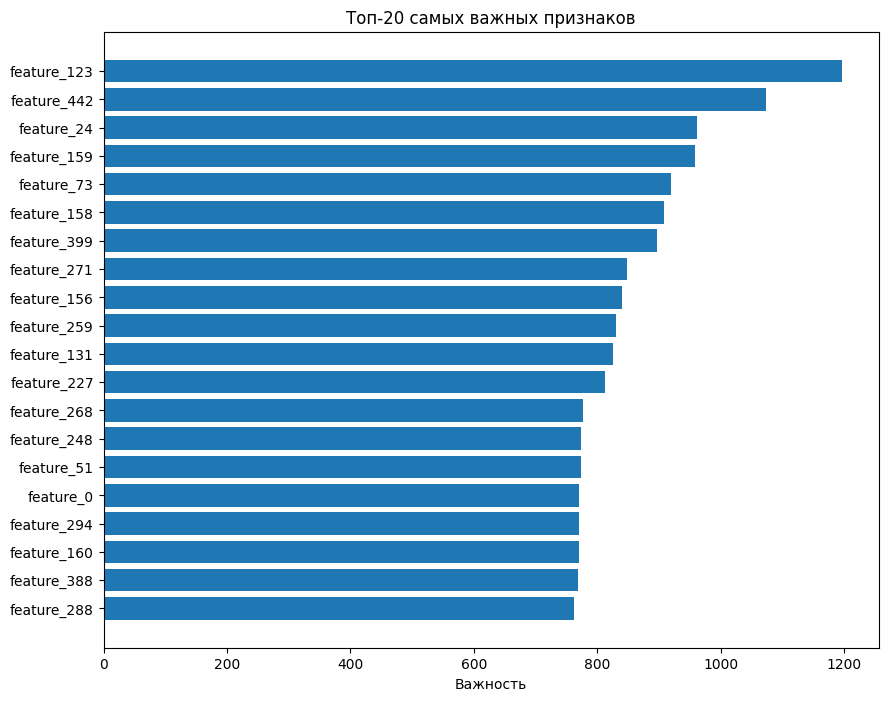

In [ ]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков:")
print(feature_importance)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Важность')
plt.title('Топ-20 самых важных признаков')
plt.gca().invert_yaxis()
plt.show()

# Для доп соревнования

Данные были обработаны в основном задании, поэтому \
Обучила отдельные модели под каждое значение колонки product, product_1 обучился хорошо, тк значений для product_1 очень много, остальные модели переобучились из-за недостатка данных \
ROC-AUC для объединённой модели выше, чем исходный, возможно так же из-за переообучения моделей

In [ ]:
params_2 = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,

    "num_leaves": 20,
    "max_depth": 5,
    "min_data_in_leaf": 1000,

    "lambda_l1": 3.0,
    "lambda_l2": 5.0,
    "min_gain_to_split": 0.1,

    "feature_fraction": 0.5,
    "bagging_fraction": 0.6,
    "bagging_freq": 2,

    "n_estimators": 3000
}

In [ ]:
# Функция для построения моделей по продуктам
def train_product_models(X_train, y_train, df_train):
    product_models = {}
    product_features = {}

    for product in ['product_1', 'product_2', 'product_3', 'product_4']:
        print(f"\n--- Обучение модели для {product} ---")

        X_product = X_train[X_train['product'] == product].copy()
        y_product = y_train[X_train['product'] == product]

        X_product = X_product.drop('product', axis=1)
        features_product = [f for f in features if f != 'product']

        product_features[product] = features_product

        if product == 'product_1' or product == 'product_4':
            model_product = LGBMClassifier(**best_params)
            model_product.fit(
                X_product, y_product,
                categorical_feature=['month', 'year']
            )
        if product == 'product_2' or product == 'product_3':
            model_product = LGBMClassifier(**params_2)
            model_product.fit(
                X_product, y_product,
                categorical_feature=['month', 'year']
            )

        product_models[product] = model_product
        print(f"Модель для {product} обучена на {len(X_product)} samples")

        model_product = LGBMClassifier(**best_params)
        model_product.fit(
            X_product, y_product,
            categorical_feature=['month', 'year']
        )

        product_models[product] = model_product
        print(f"Модель для {product} обучена на {len(X_product)} samples")

    return product_models, product_features

product_models, product_features = train_product_models(X_train, y_train, df_train)

print("--- Анализ пересечения признаков ---")
all_features_set = set([f for f in features if f != 'product'])

for product in ['product_1', 'product_2', 'product_3', 'product_4']:
    product_feats = set(product_features[product])
    intersection = all_features_set.intersection(product_feats)
    overlap_percent = len(intersection) / len(all_features_set) * 100
    print(f"{product}: {overlap_percent:.1f}% общих признаков с общей моделью")



--- Обучение модели для product_1 ---
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Met categorical feature whi

In [ ]:
# Функция для построения ROC-AUC по месяцам
def plot_monthly_roc_comparison(product_models, general_model, X_train, y_train, df_train):
    months = sorted(df_train['month_dt'].unique())

    for product in ['product_1', 'product_2', 'product_3', 'product_4']:
        plt.figure(figsize=(12, 8))

        monthly_auc_general = []
        monthly_auc_product = []
        month_labels = []

        for month in months:
            month_mask = (df_train['month_dt'] == month) & (X_train['product'] == product)
            X_month = X_train[month_mask].copy()
            y_month = y_train[month_mask]

            if len(X_month) == 0:
                continue

            X_month_general = X_month.copy()
            X_month_product = X_month.drop('product', axis=1)

            y_pred_general = general_model.predict_proba(X_month_general)[:, 1]
            auc_general = roc_auc_score(y_month, y_pred_general)
            monthly_auc_general.append(auc_general)

            y_pred_product = product_models[product].predict_proba(X_month_product)[:, 1]
            auc_product = roc_auc_score(y_month, y_pred_product)
            monthly_auc_product.append(auc_product)

            month_labels.append(month.strftime('%Y-%m'))

        plt.plot(month_labels, monthly_auc_general, marker='o', label='Общая модель', linewidth=2)
        plt.plot(month_labels, monthly_auc_product, marker='s', label=f'Модель {product}', linewidth=2)

        plt.title(f'ROC-AUC по месяцам: {product}', fontsize=14)
        plt.xlabel('Месяц', fontsize=12)
        plt.ylabel('ROC-AUC', fontsize=12)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

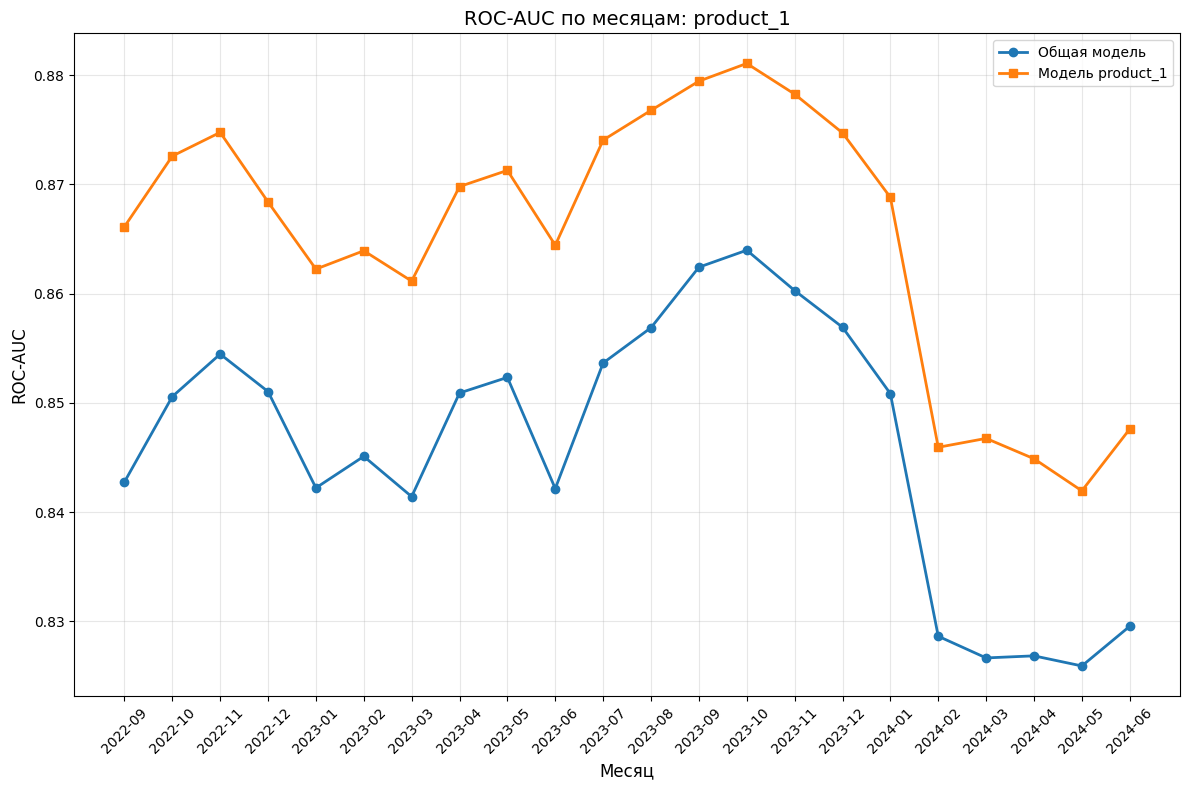

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

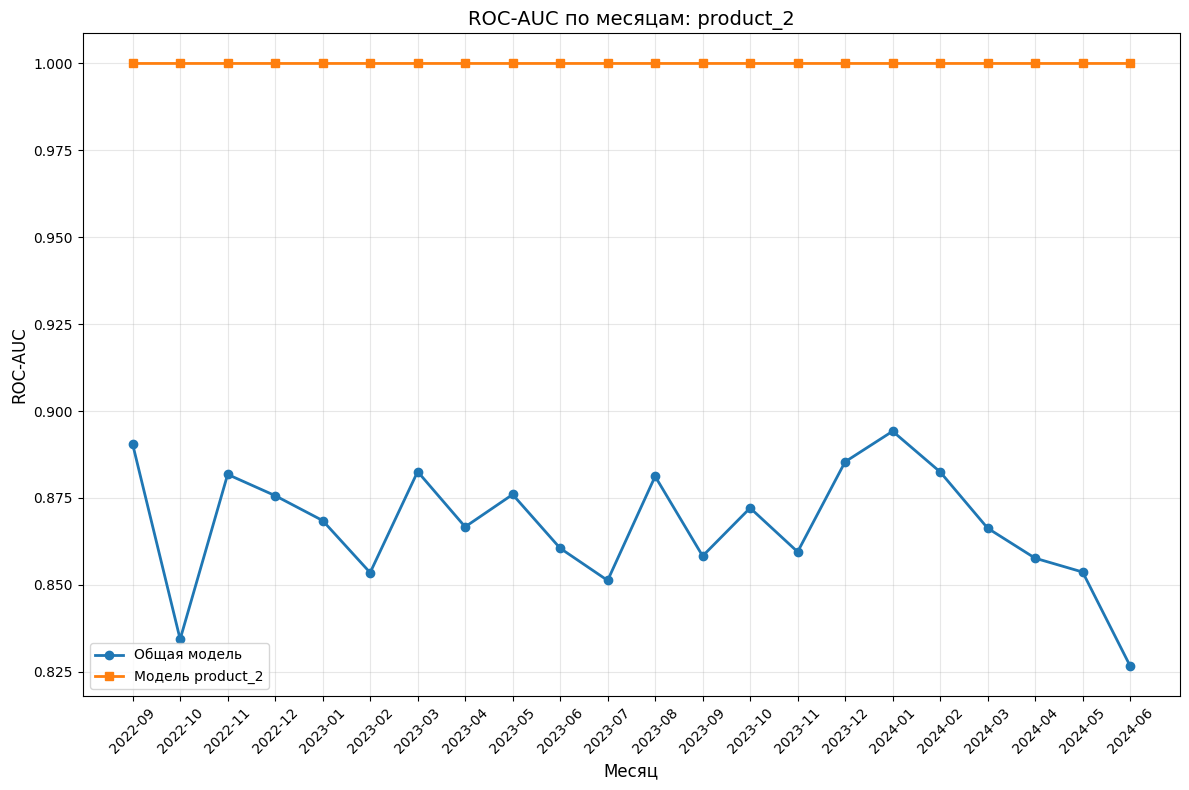

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

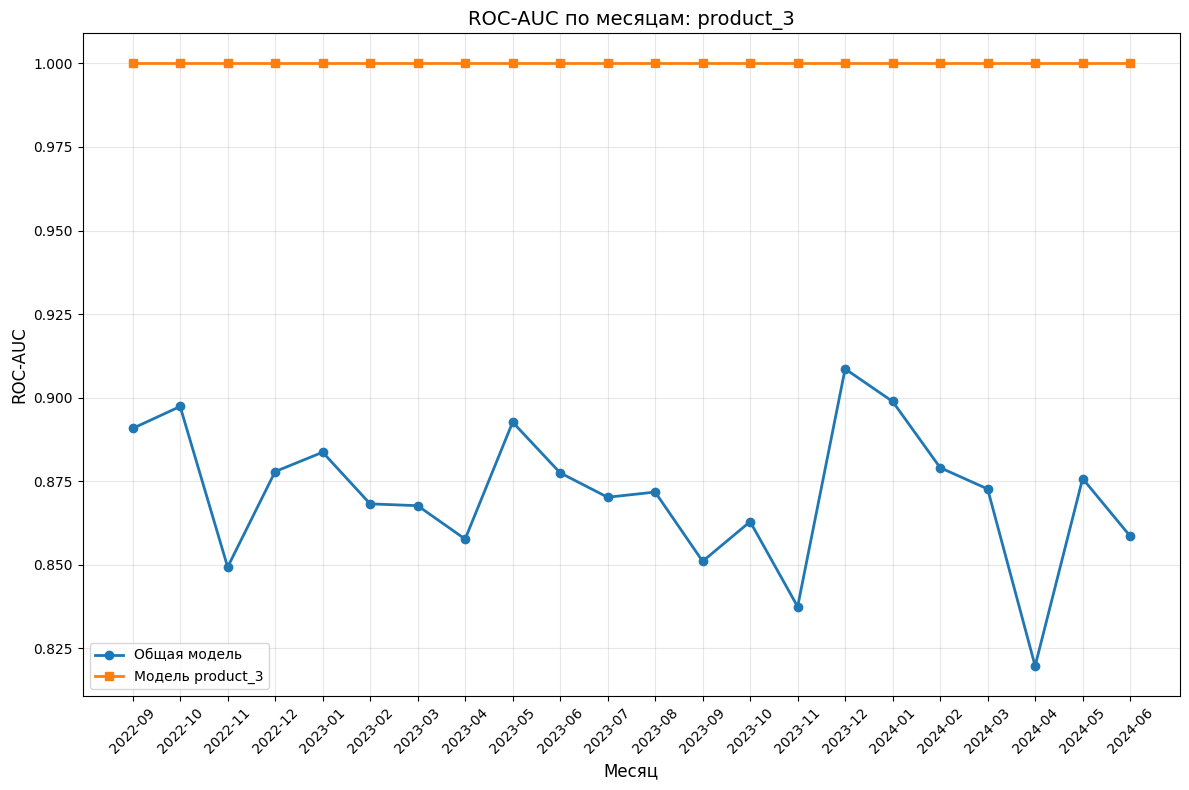

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

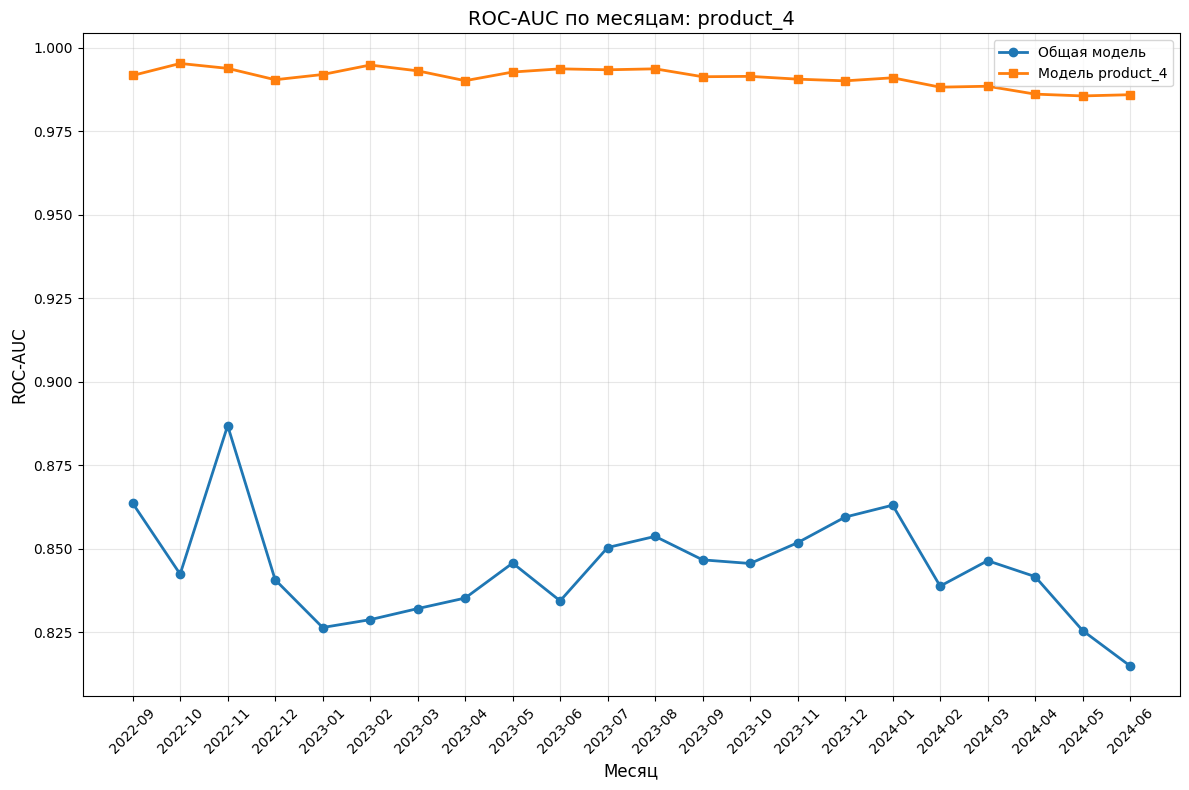

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_best_model
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parame

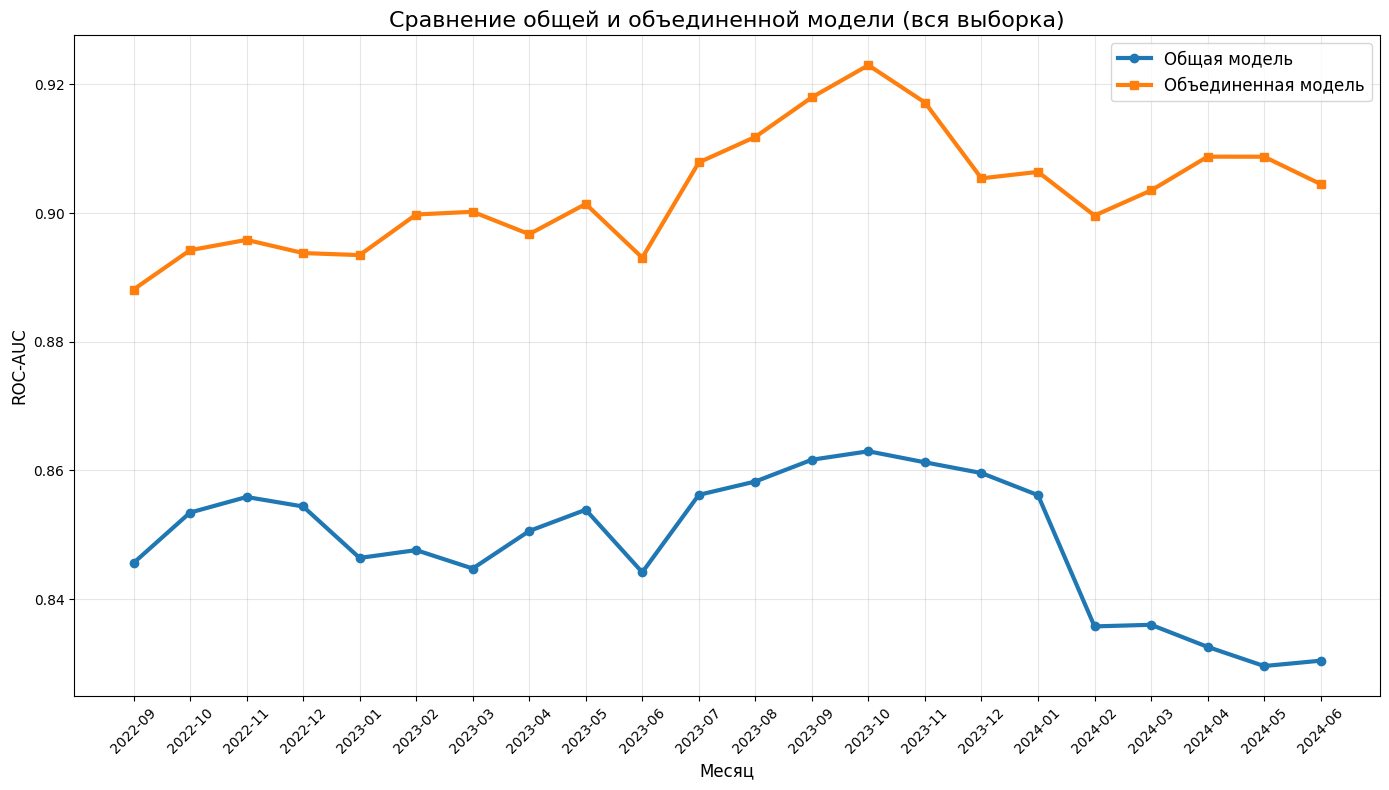

In [ ]:

plot_monthly_roc_comparison(product_models, model, X_train, y_train, df_train)

def combined_model_predict(X, product_models):
    predictions = np.zeros(len(X))

    for product in ['product_1', 'product_2', 'product_3', 'product_4']:
        product_mask = X['product'] == product
        if product_mask.sum() > 0:
            X_product = X[product_mask].drop('product', axis=1)
            preds = product_models[product].predict_proba(X_product)[:, 1]
            predictions[product_mask] = preds

    return predictions

def plot_combined_vs_general_roc(product_models, general_model, X_train, y_train, df_train):
    months = sorted(df_train['month_dt'].unique())

    plt.figure(figsize=(14, 8))

    monthly_auc_general = []
    monthly_auc_combined = []
    month_labels = []

    for month in months:
        month_mask = (df_train['month_dt'] == month)
        X_month = X_train[month_mask].copy()
        y_month = y_train[month_mask]

        if len(X_month) == 0:
            continue

        y_pred_general = general_model.predict_proba(X_month)[:, 1]
        auc_general = roc_auc_score(y_month, y_pred_general)
        monthly_auc_general.append(auc_general)

        y_pred_combined = combined_model_predict(X_month, product_models)
        auc_combined = roc_auc_score(y_month, y_pred_combined)
        monthly_auc_combined.append(auc_combined)

        month_labels.append(month.strftime('%Y-%m'))

    plt.plot(month_labels, monthly_auc_general, marker='o', label='Общая модель', linewidth=3)
    plt.plot(month_labels, monthly_auc_combined, marker='s', label='Объединенная модель', linewidth=3)

    plt.title('Сравнение общей и объединенной модели (вся выборка)', fontsize=16)
    plt.xlabel('Месяц', fontsize=12)
    plt.ylabel('ROC-AUC', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_combined_vs_general_roc(product_models, model, X_train, y_train, df_train)

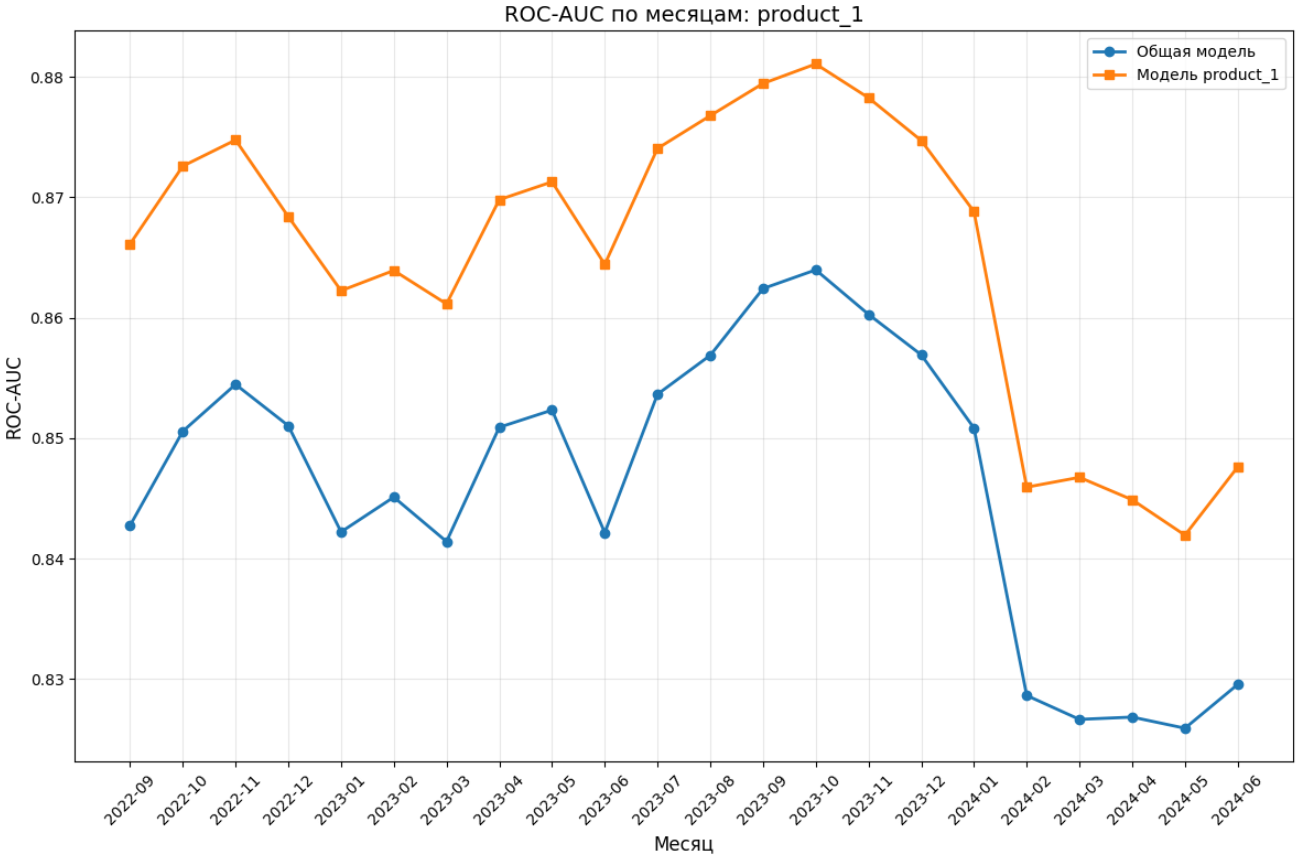

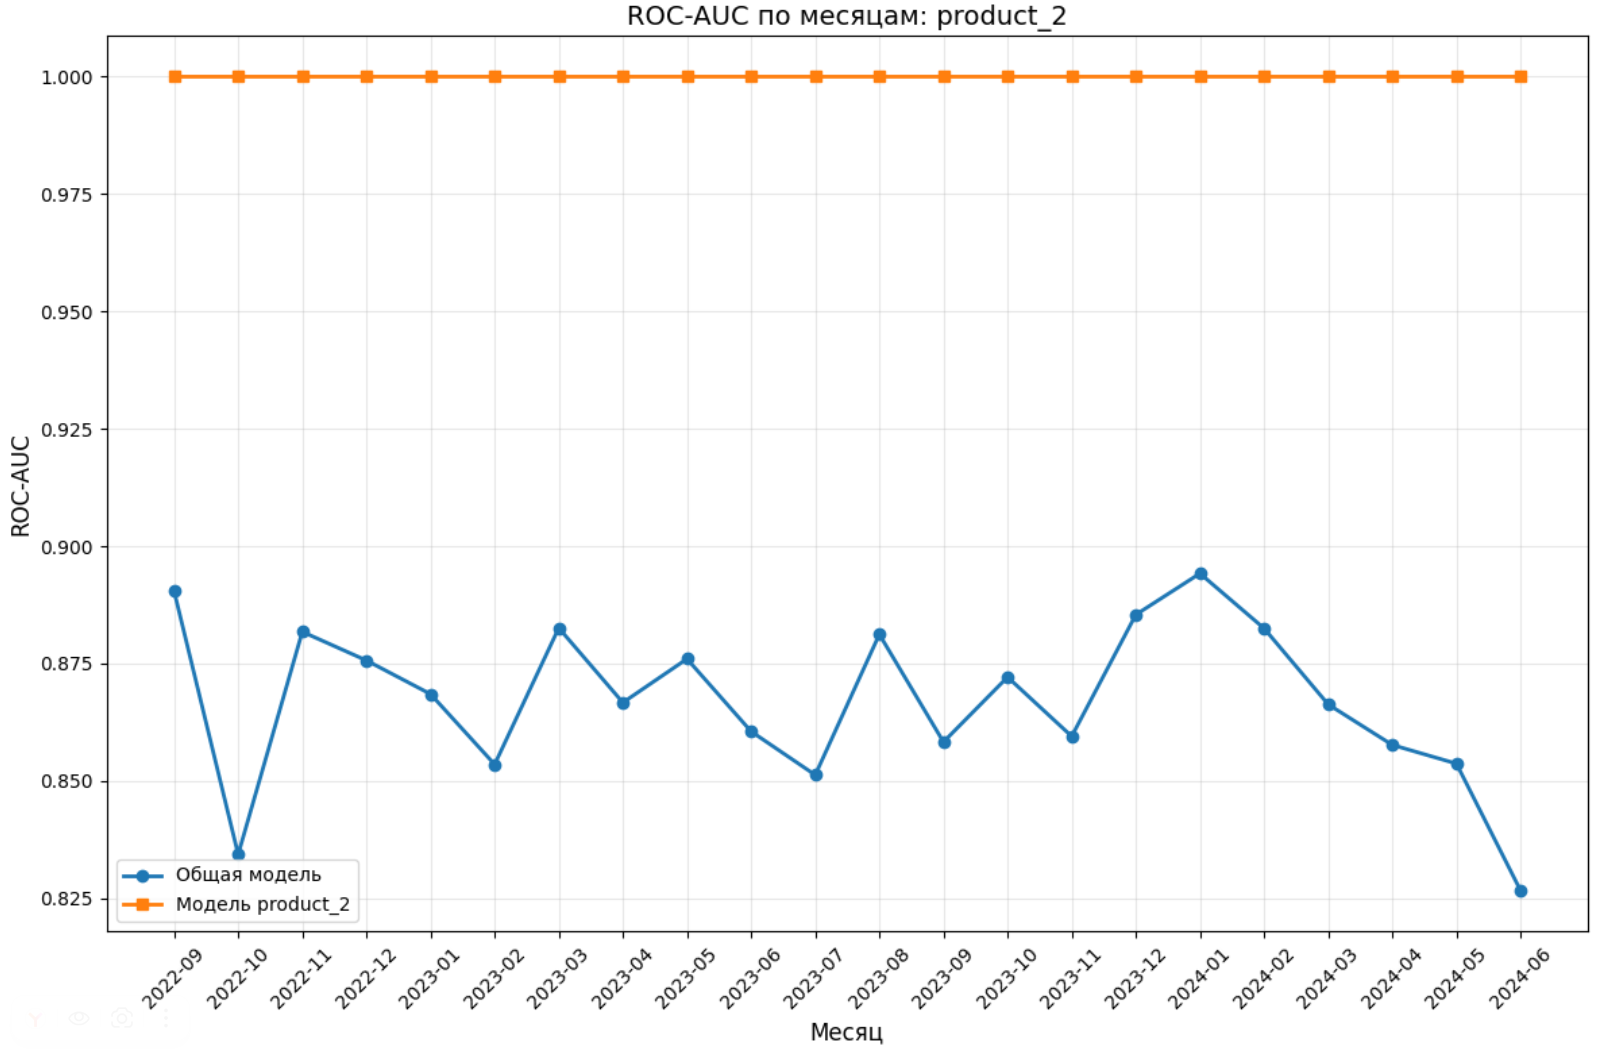

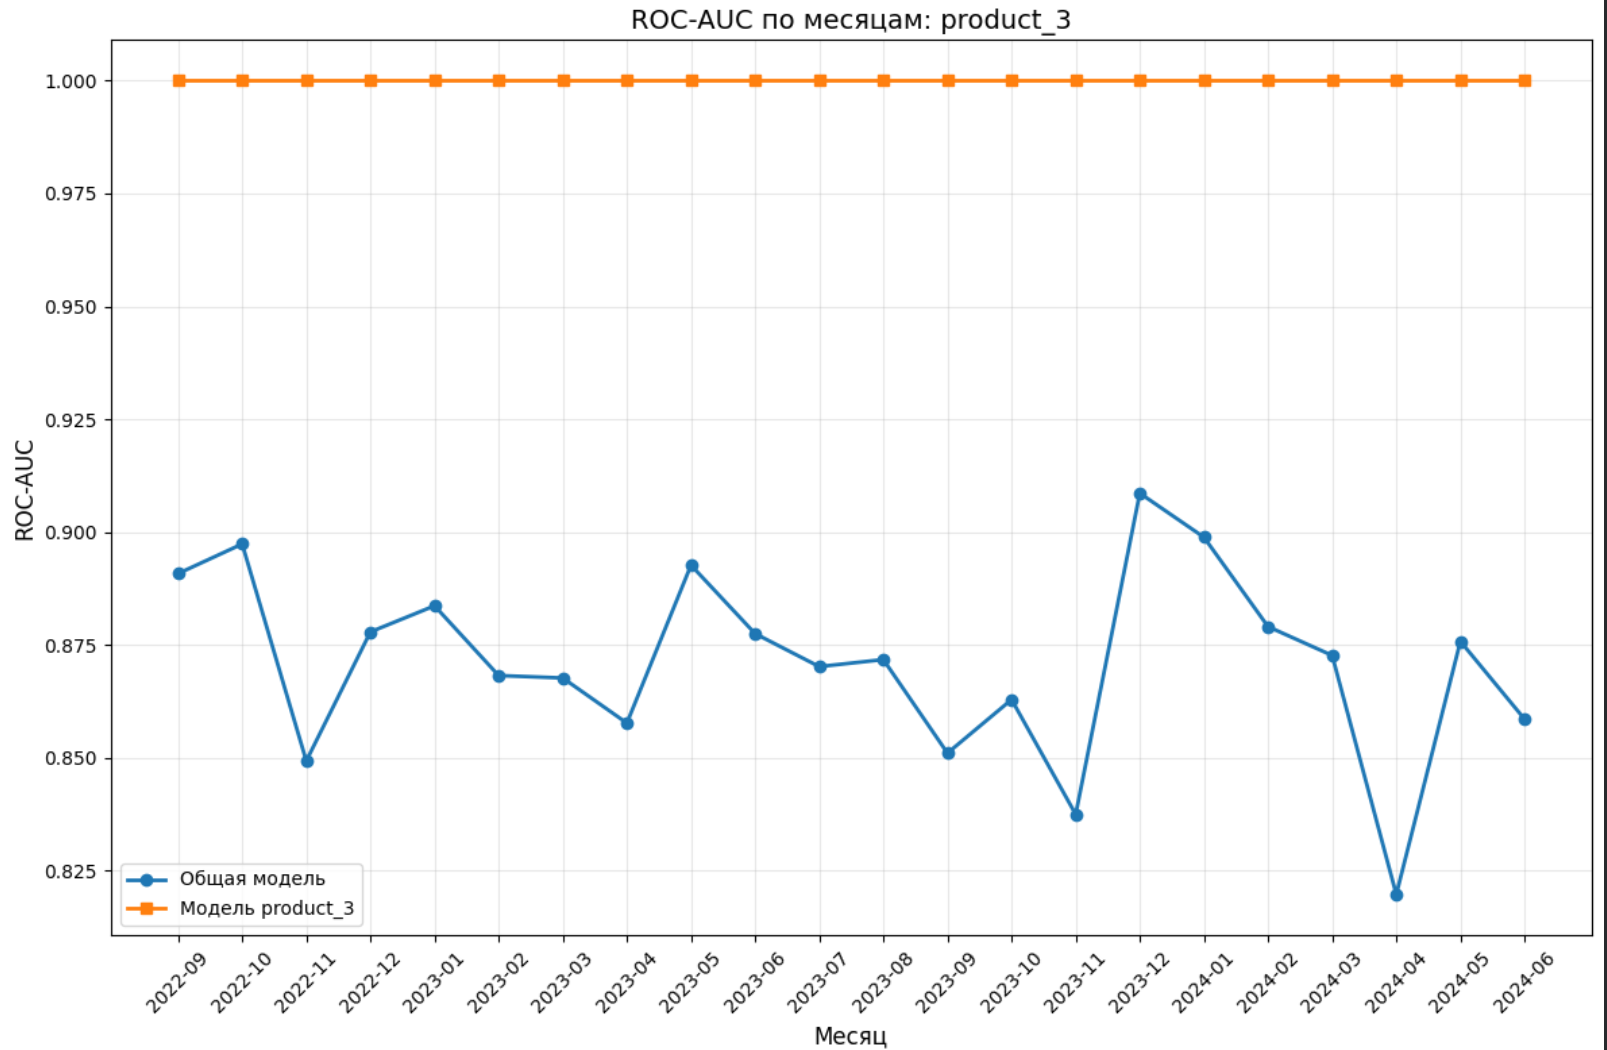

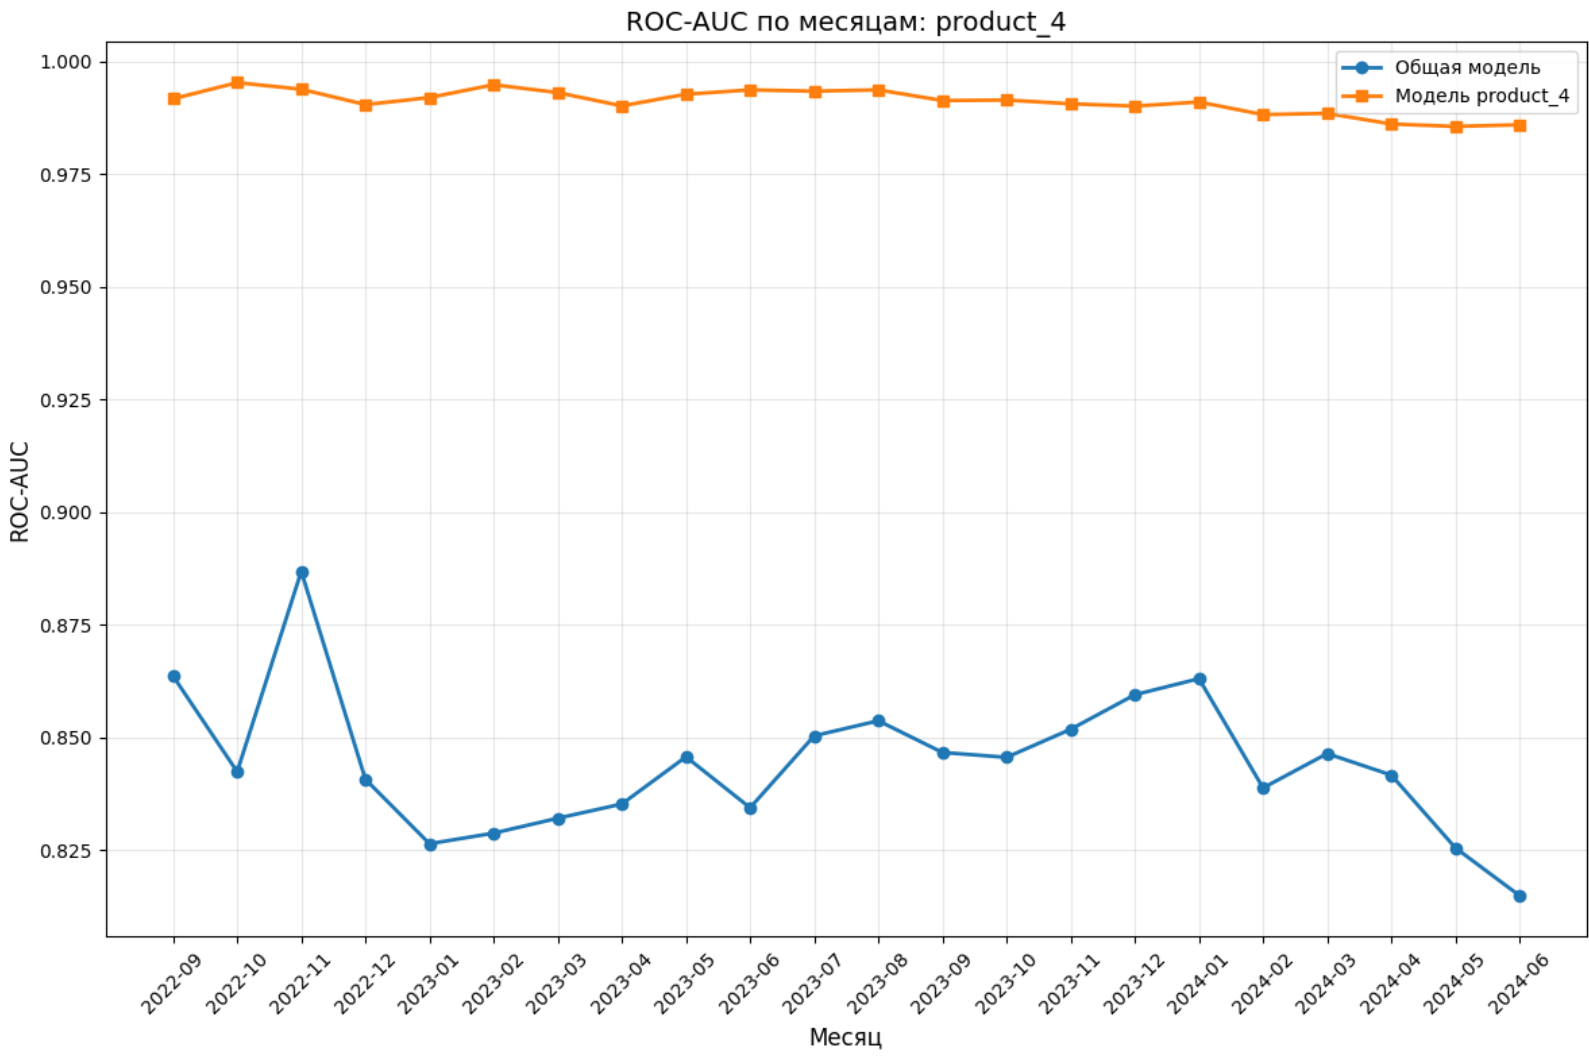

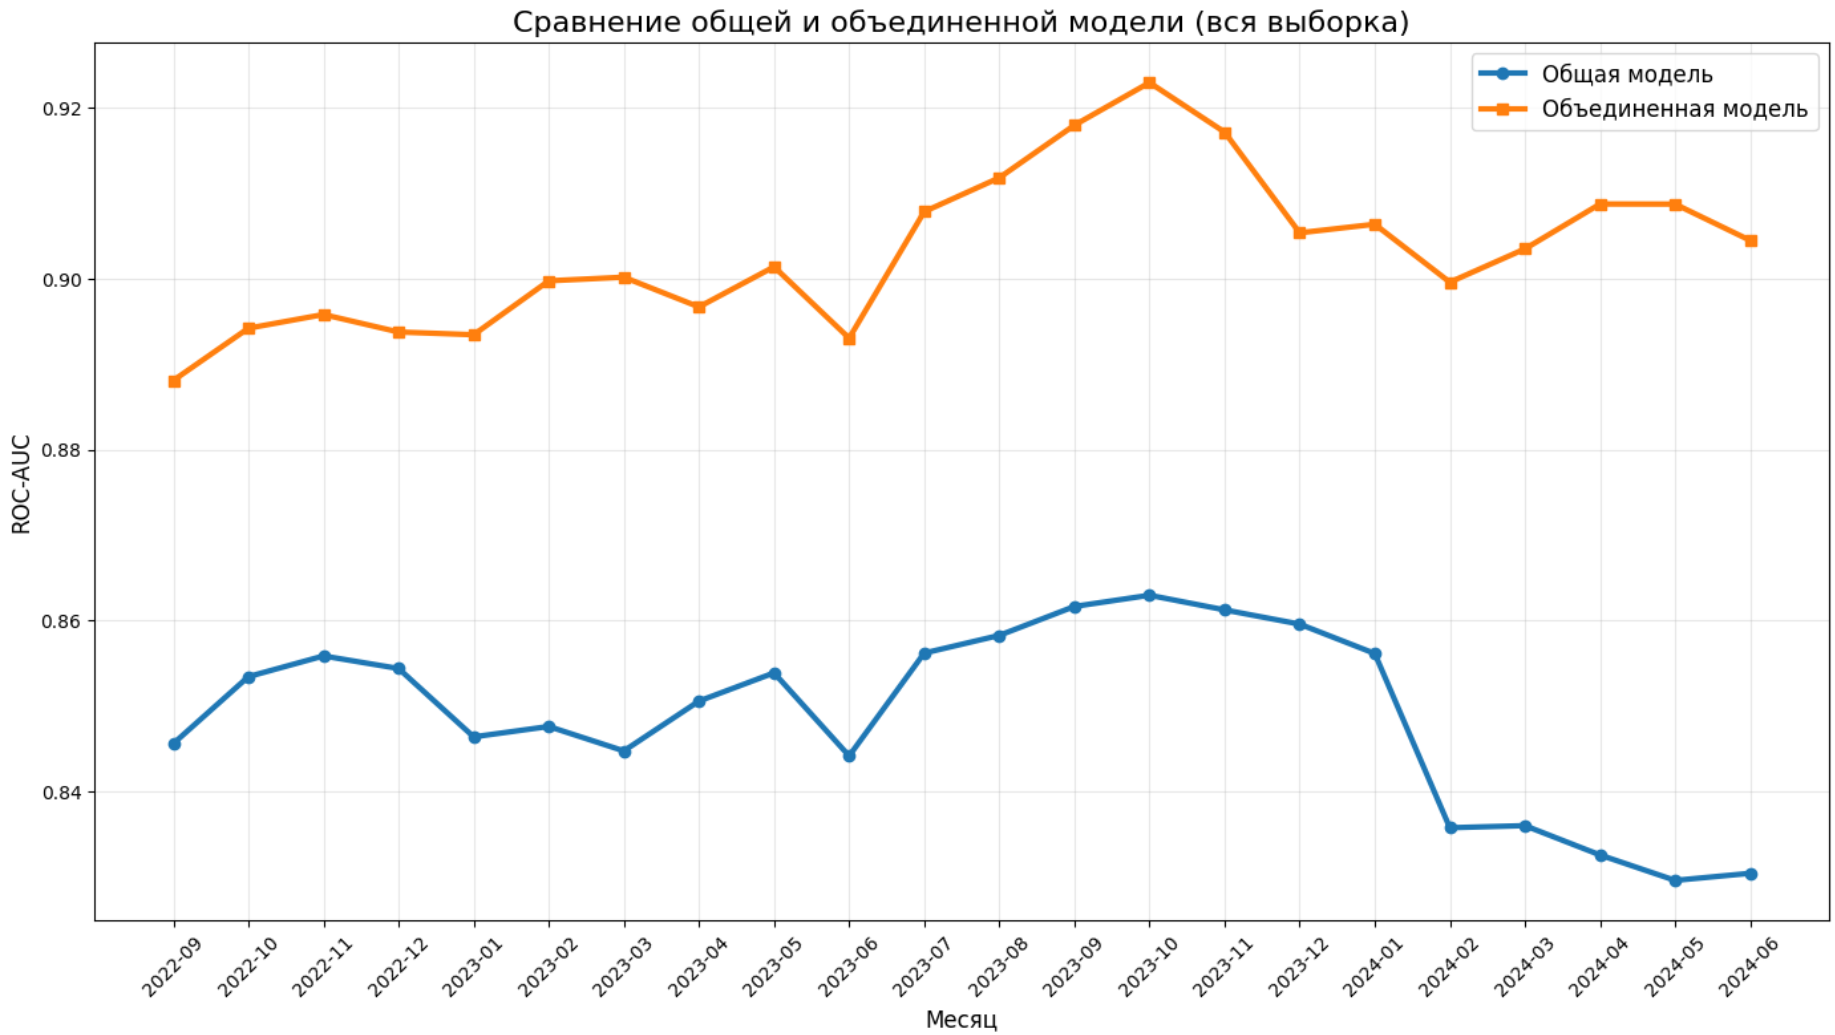

Пропущенные значения в train:
Всего колонок с пропусками: 486
Общее количество пропусков: 61575466


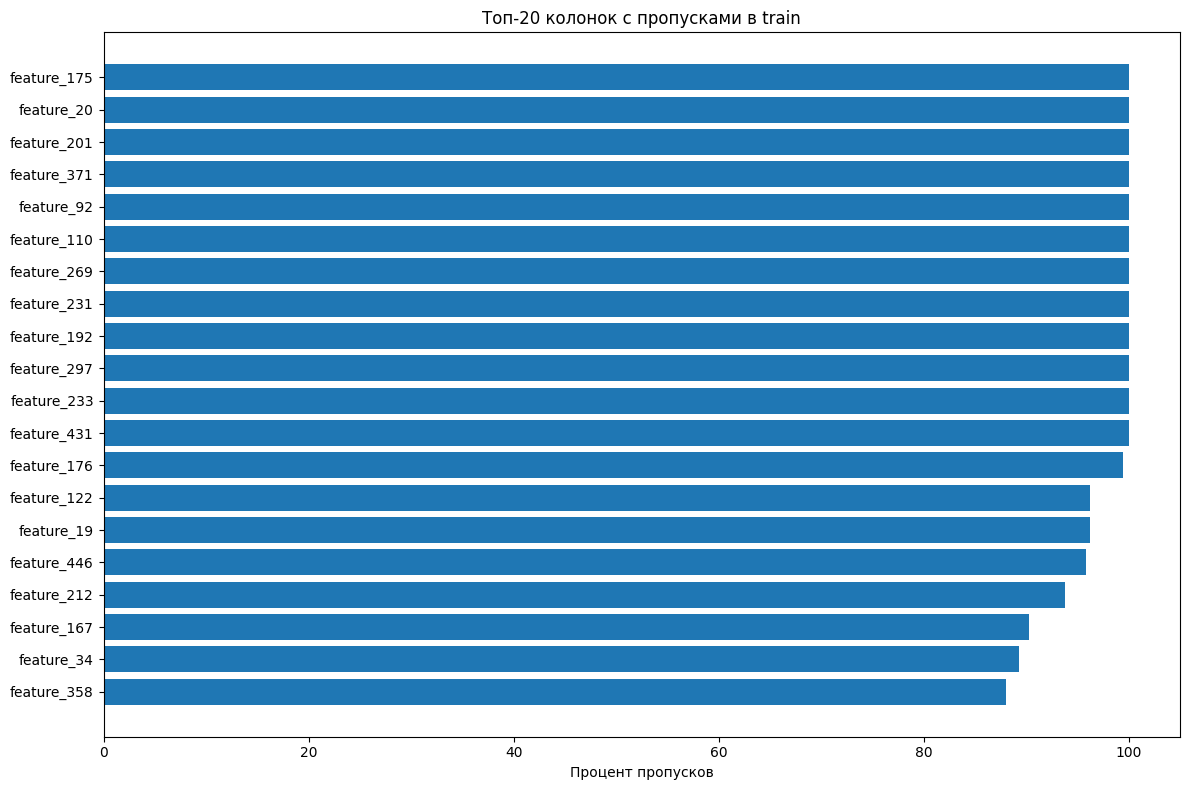

Пропущенные значения в test:
Всего колонок с пропусками: 486
Общее количество пропусков: 6450506


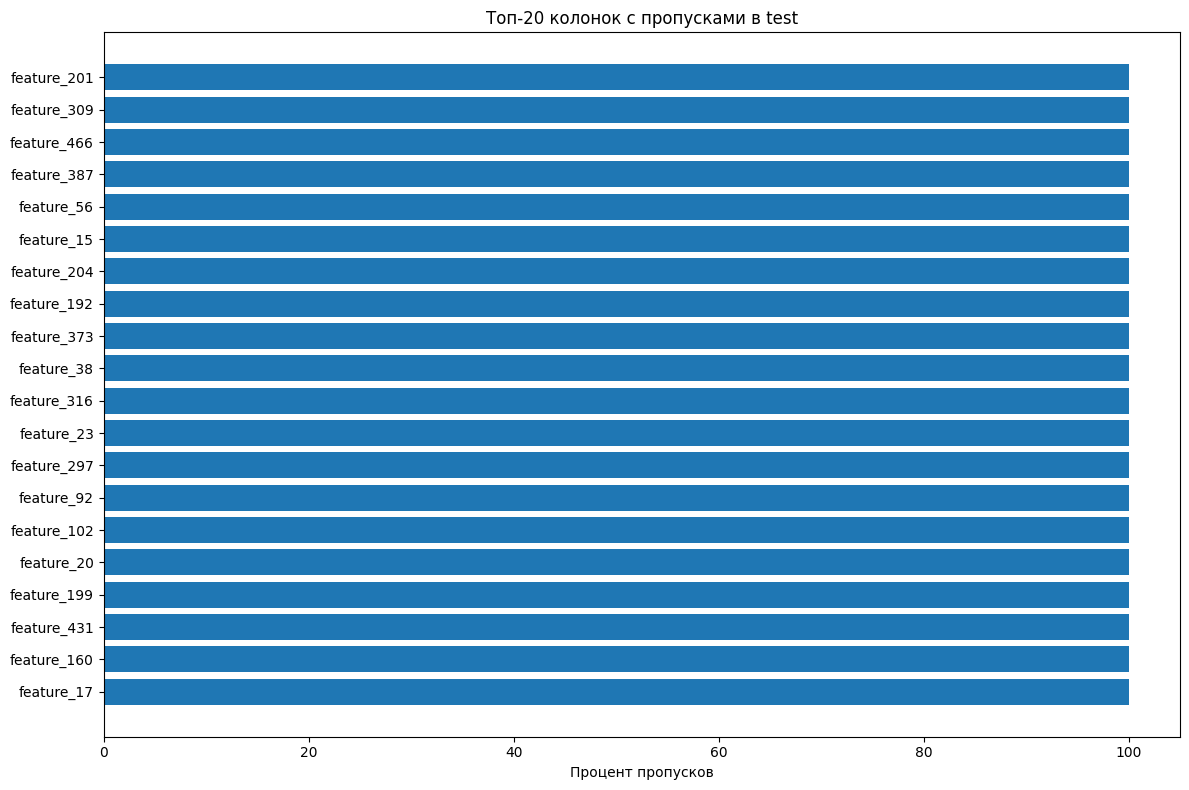

In [ ]:
# Анализ пропущенных значений
def analyze_missing_values(df, dataset_name):
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100

    missing_df = pd.DataFrame({
        'Колонка': missing_data.index,
        'Пропущенные значения': missing_data.values,
        'Процент пропусков': missing_percent.values
    })

    missing_df = missing_df[missing_df['Пропущенные значения'] > 0].sort_values('Пропущенные значения', ascending=False)

    print(f"Пропущенные значения в {dataset_name}:")
    print(f"Всего колонок с пропусками: {len(missing_df)}")
    print(f"Общее количество пропусков: {missing_data.sum()}")

    if len(missing_df) > 0:
        plt.figure(figsize=(12, 8))
        top_missing = missing_df.head(20)
        plt.barh(top_missing['Колонка'], top_missing['Процент пропусков'])
        plt.xlabel('Процент пропусков')
        plt.title(f'Топ-20 колонок с пропусками в {dataset_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return missing_df

missing_train = analyze_missing_values(df_train, "train")
missing_test = analyze_missing_values(df_test, "test")

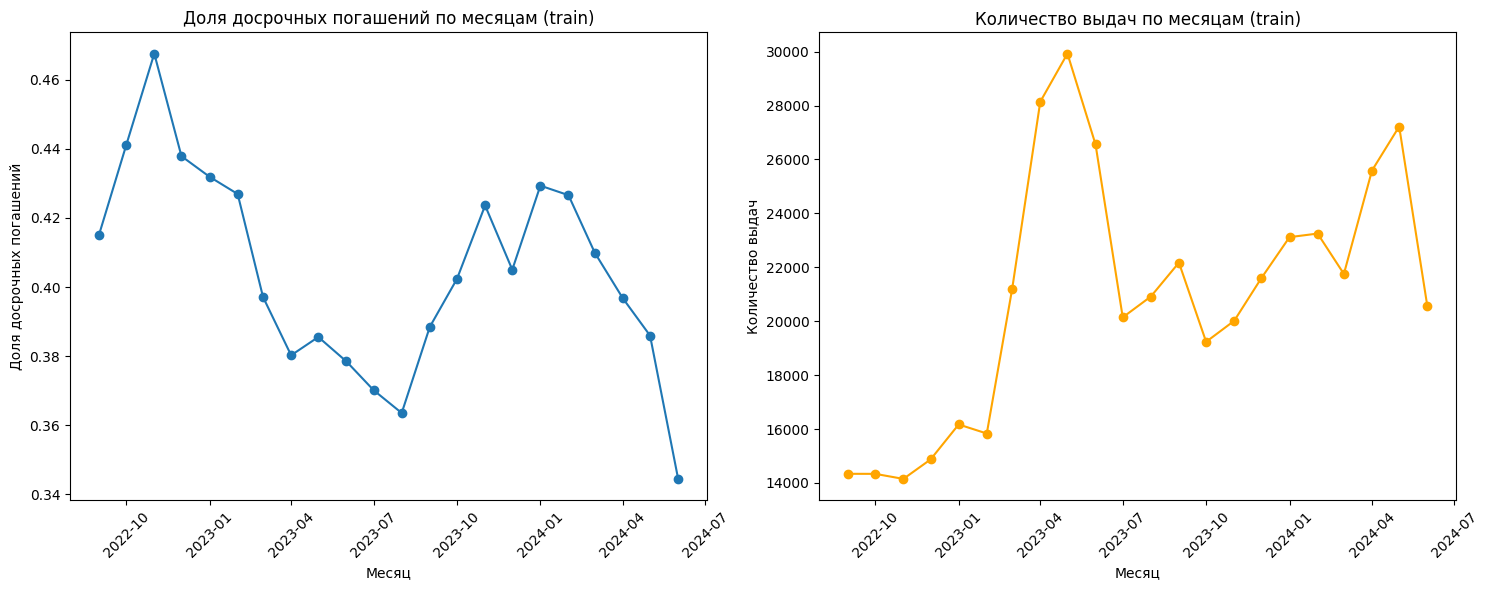

In [ ]:
# Анализ распределения по месяцам
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
monthly_target = df_train_processed.groupby('month_dt')['a6_flg'].mean()
plt.plot(monthly_target.index, monthly_target.values, marker='o')
plt.title('Доля досрочных погашений по месяцам (train)')
plt.xlabel('Месяц')
plt.ylabel('Доля досрочных погашений')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
monthly_count = df_train_processed.groupby('month_dt').size()
plt.plot(monthly_count.index, monthly_count.values, marker='o', color='orange')
plt.title('Количество выдач по месяцам (train)')
plt.xlabel('Месяц')
plt.ylabel('Количество выдач')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Распределение product в train:
product
product_1    363057
product_4     66330
product_2     17405
product_3     14334
Name: count, dtype: Int64

Распределение product в test:
product
product_1    18570
product_2     9800
product_3     6261
product_4     4243
Name: count, dtype: Int64


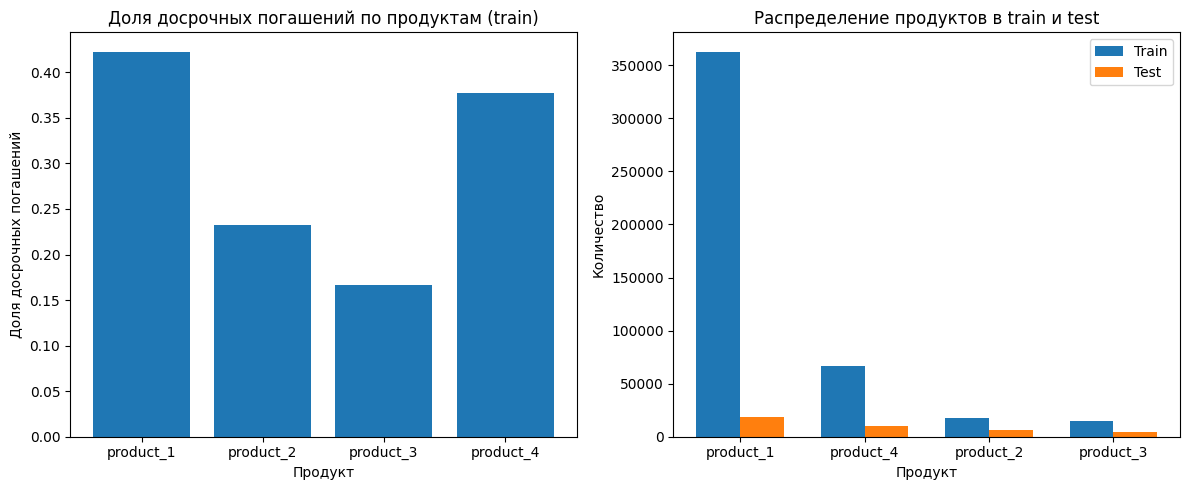

In [ ]:
print("Распределение product в train:")
print(df_train_processed['product'].value_counts())
print("\nРаспределение product в test:")
print(df_test_processed['product'].value_counts())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
product_target = df_train_processed.groupby('product')['a6_flg'].mean()
plt.bar(product_target.index, product_target.values)
plt.title('Доля досрочных погашений по продуктам (train)')
plt.xlabel('Продукт')
plt.ylabel('Доля досрочных погашений')

plt.subplot(1, 2, 2)
product_count_train = df_train_processed['product'].value_counts()
product_count_test = df_test_processed['product'].value_counts()
x = np.arange(len(product_count_train))
width = 0.35

plt.bar(x - width/2, product_count_train.values, width, label='Train')
plt.bar(x + width/2, product_count_test.values, width, label='Test')
plt.title('Распределение продуктов в train и test')
plt.xlabel('Продукт')
plt.ylabel('Количество')
plt.legend()
plt.xticks(x, product_count_train.index)

plt.tight_layout()
plt.show()

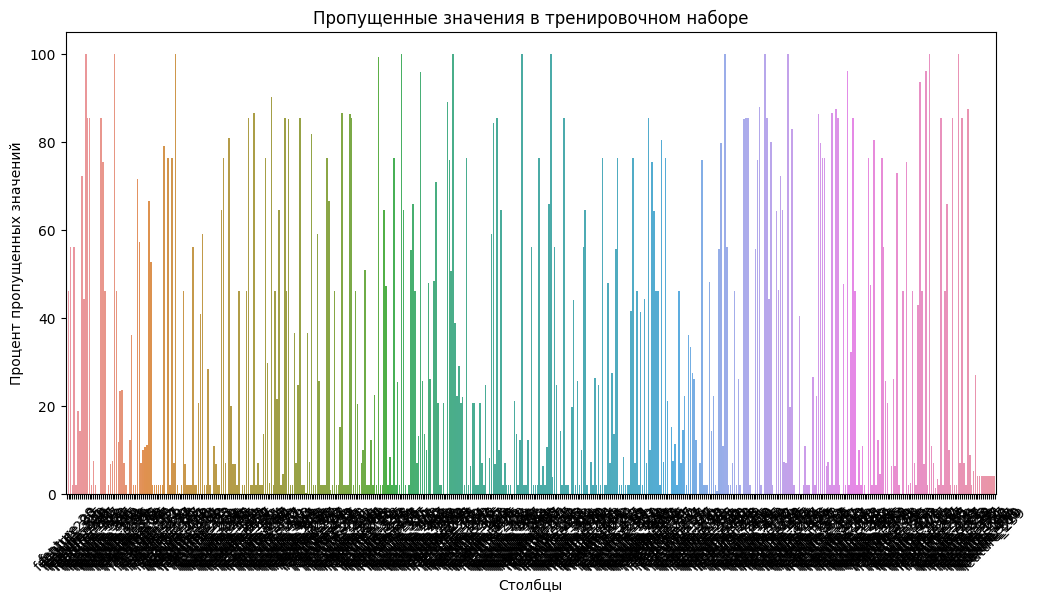

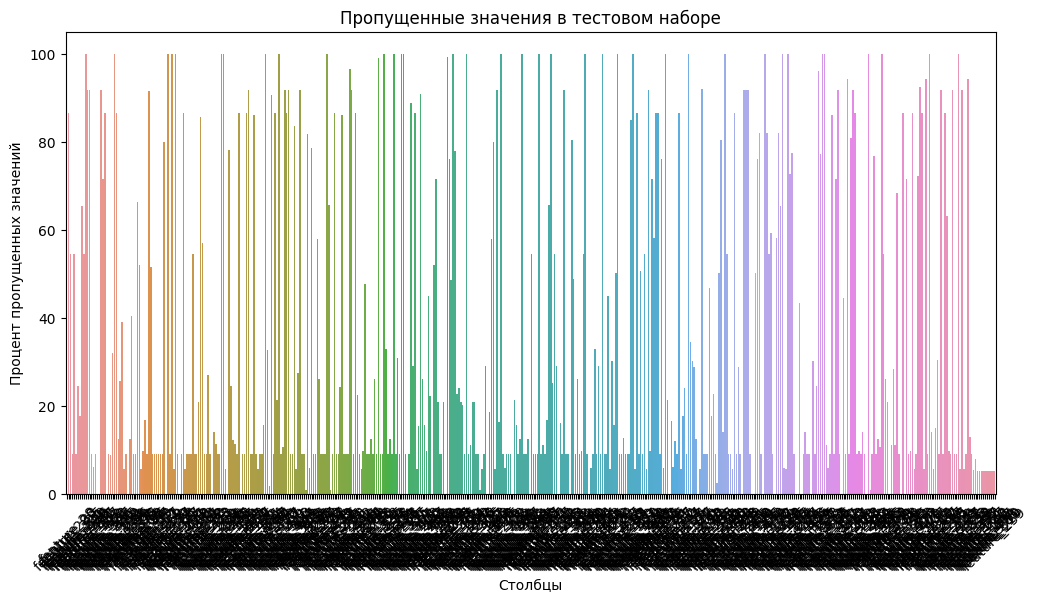

In [ ]:
def plot_missing_values(df, title="Пропущенные значения по столбцам"):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_percent[missing_percent > 0].index,
                y=missing_percent[missing_percent > 0].values)
    plt.title(title)
    plt.ylabel("Процент пропущенных значений")
    plt.xlabel("Столбцы")
    plt.xticks(rotation=45)
    plt.show()

plot_missing_values(df_train, "Пропущенные значения в тренировочном наборе")
plot_missing_values(df_test, "Пропущенные значения в тестовом наборе")


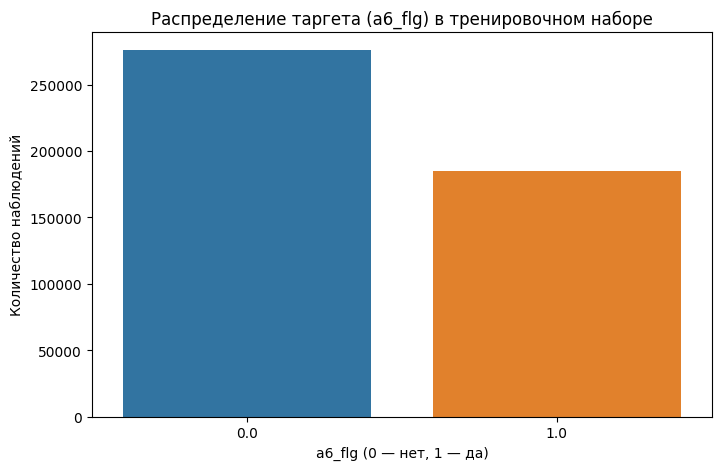

Распределение таргета:
a6_flg
0.0    0.598791
1.0    0.401209
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='a6_flg', data=df_train)
plt.title("Распределение таргета (a6_flg) в тренировочном наборе")
plt.xlabel("a6_flg (0 — нет, 1 — да)")
plt.ylabel("Количество наблюдений")
plt.show()

print("Распределение таргета:")
print(df_train['a6_flg'].value_counts(normalize=True))


In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide', 'Depthwise']),
        'use_best_model': True,
        'eval_metric': 'AUC',
        'thread_count': -1,
        'verbose': 0
    }

    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 16, 128)

    cat_features = [X_train.columns.get_loc('product')]

    model = CatBoostClassifier(**params)

    X_train_part, X_val, y_train_part, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model.fit(
        X_train_part, y_train_part,
        cat_features=cat_features,
        eval_set=(X_val, y_val)
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)

    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)


print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC:", study.best_value)


[I 2025-11-16 22:24:51,156] A new study created in memory with name: no-name-3a4eb8fa-c7aa-4854-a408-3911a6af523d
[I 2025-11-16 22:31:58,574] Trial 0 finished with value: 0.7338956136860098 and parameters: {'iterations': 405, 'learning_rate': 0.09465180468182868, 'depth': 4, 'l2_leaf_reg': 1.8002516617063224, 'random_strength': 0.5329717139168035, 'bagging_temperature': 0.20429307724113765, 'min_data_in_leaf': 2, 'grow_policy': 'Lossguide', 'max_leaves': 54}. Best is trial 0 with value: 0.7338956136860098.
[I 2025-11-16 22:56:46,269] Trial 1 finished with value: 0.733241341387179 and parameters: {'iterations': 651, 'learning_rate': 0.10541891315239835, 'depth': 10, 'l2_leaf_reg': 7.709044720775489, 'random_strength': 1.4597255777041993, 'bagging_temperature': 0.03440727827825463, 'min_data_in_leaf': 12, 'grow_policy': 'Lossguide', 'max_leaves': 63}. Best is trial 0 with value: 0.7338956136860098.
[I 2025-11-16 22:57:46,955] Trial 2 finished with value: 0.7291562736862761 and parameters